## 准备数据

In [1]:
import os
import datetime

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

printbar()


================================================================================2021-02-01 17:04:34


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
from torch import nn 
from torch.utils.data import Dataset,DataLoader,TensorDataset

In [3]:
dftrain_raw = pd.read_csv('./data/Titanic/train.csv')
dftest_raw = pd.read_csv('./data/Titanic/test.csv')
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


字段说明：

* Survived:0代表死亡，1代表存活【y标签】
* Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
* Name:乘客姓名 【舍去】
* Sex:乘客性别 【转换成bool特征】
* Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
* SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
* Parch:乘客父母/孩子的个数(整数值)【数值特征】
* Ticket:票号(字符串)【舍去】
* Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
* Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
* Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】

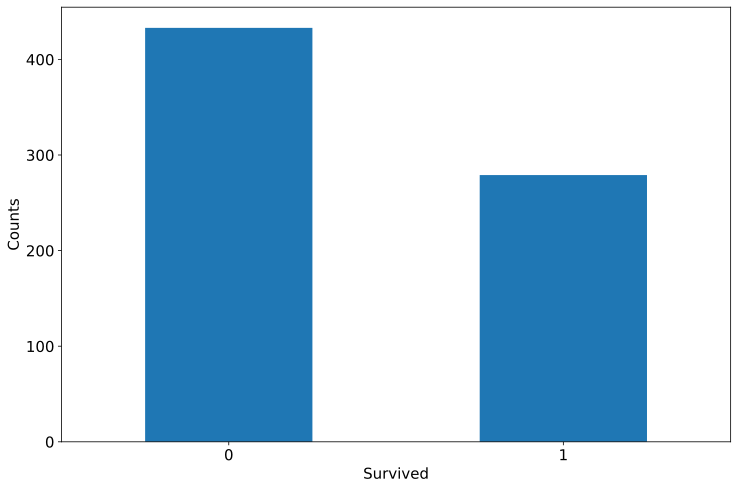

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

ax = dftrain_raw['Survived'].value_counts().plot(kind='bar', figsize=(12,8), fontsize=15, rot=0)
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('Survived', fontsize=15)
plt.show()

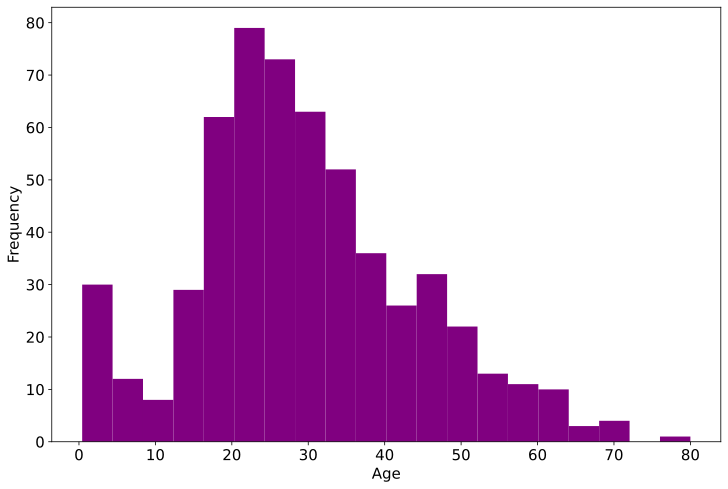

In [5]:
ax = dftrain_raw['Age'].plot(kind = 'hist',bins = 20,color= 'purple', figsize = (12,8),fontsize=15)
ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

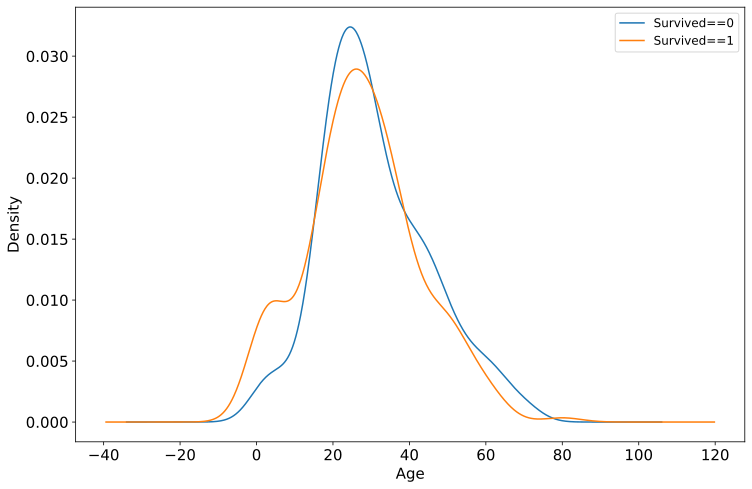

In [6]:
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'density', figsize = (12,8),fontsize=15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind = 'density', figsize = (12,8),fontsize=15)
ax.legend(['Survived==0','Survived==1'],fontsize = 12)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

In [7]:
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

x_train = preprocessing(dftrain_raw).values
y_train = dftrain_raw[['Survived']].values

x_test = preprocessing(dftest_raw).values
y_test = dftest_raw[['Survived']].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

print("y_train.shape =", y_train.shape )
print("y_test.shape =", y_test.shape )

x_train.shape = (712, 15)
x_test.shape = (179, 15)
y_train.shape = (712, 1)
y_test.shape = (179, 1)


In [8]:
dl_train = DataLoader(TensorDataset(torch.tensor(x_train).float(), torch.tensor(y_train).float()), shuffle=True, batch_size = 8)
dl_valid = DataLoader(TensorDataset(torch.tensor(x_test).float(), torch.tensor(y_test).float()), shuffle=False, batch_size = 8)

In [9]:
for features, labels in dl_train:
    print(features)
    print(labels)
    break

tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  1.0000, 28.0000,  0.0000,  1.0000,
          0.0000, 82.1708,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000, 13.0000,  0.0000,  0.0000,
          1.0000, 19.5000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000, 45.0000,  0.0000,  0.0000,
          0.0000, 13.5000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  7.8958,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  1.0000, 23.0000,  0.0000,  0.0000,
          0.0000, 10.5000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  1.0000, 49.0000,  0.0000,  1.0000,
          0.0000, 89.1042,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0

## 定义模型

In [10]:
def create_net():
    net = nn.Sequential()
    net.add_module('linear1', nn.Linear(15, 20))
    net.add_module('relu1', nn.ReLU())
    net.add_module('linear2', nn.Linear(20, 15))
    net.add_module('relu2', nn.ReLU())
    net.add_module('linear3', nn.Linear(15, 1))
    net.add_module('sigmoid', nn.Sigmoid())
    return net

net = create_net()
print(net)

Sequential(
  (linear1): Linear(in_features=15, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [11]:
from sklearn.metrics import accuracy_score

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)
metric_func = lambda y_pred,y_true : accuracy_score(y_true.data.numpy(), y_pred.data.numpy()>0.5)
metric_name = 'accuracy'

## 训练模型

In [12]:
epochs = 10
log_step_freq = 30

dfhistory = pd.DataFrame(columns = ["epoch","loss",metric_name,"val_loss","val_"+metric_name]) 
print("Start Training...")
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("=========="*8 + "%s"%nowtime)

for epoch in range(epochs):
    # 1. 训练
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    for step, (features, labels) in enumerate(dl_train, 1):
        # 清零梯度
        optimizer.zero_grad()
        # 正向传播求损失
        pred = net(features)
        loss = loss_func(pred, labels)
        metric = metric_func(pred, labels)
        # 反向传播求梯度
        loss.backward()
        optimizer.step()
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step%log_step_freq == 0:   
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                  (step, loss_sum/step, metric_sum/step))
    # 2. 验证
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    for val_step, (features,labels) in enumerate(dl_valid, 1):
        # 关闭梯度计算
        with torch.no_grad():
            predictions = net(features)
            val_loss = loss_func(predictions,labels)
            val_metric = metric_func(predictions,labels)
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    info = (epoch, loss_sum/step, metric_sum/step, 
            val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
     # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
          "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

print('Finished Training...')

Start Training...
================================================================================2021-02-01 17:04:38
[step = 30] loss: 0.641, accuracy: 0.629
[step = 60] loss: 0.639, accuracy: 0.662

EPOCH = 0, loss = 0.617,accuracy  = 0.677, val_loss = 0.636, val_accuracy = 0.687

================================================================================2021-02-01 17:04:38
[step = 30] loss: 0.591, accuracy: 0.700
[step = 60] loss: 0.586, accuracy: 0.708

EPOCH = 1, loss = 0.557,accuracy  = 0.733, val_loss = 0.462, val_accuracy = 0.746

================================================================================2021-02-01 17:04:38
[step = 30] loss: 0.556, accuracy: 0.713
[step = 60] loss: 0.540, accuracy: 0.735

EPOCH = 2, loss = 0.519,accuracy  = 0.753, val_loss = 0.434, val_accuracy = 0.788

================================================================================2021-02-01 17:04:38
[step = 30] loss: 0.517, accuracy: 0.783
[step = 60] loss: 0.494, accuracy: 0.792

E

## 评估模型

In [13]:
dfhistory 

,epoch,loss,accuracy,val_loss,val_accuracy
-1,0.0,0.616996,0.676966,0.635650,0.686594
0,1.0,0.557091,0.733146,0.462076,0.746377
1,2.0,0.519047,0.752809,0.434240,0.788043
2,3.0,0.491142,0.790730,0.416316,0.804348
3,4.0,0.481114,0.782303,0.441325,0.804348
4,5.0,0.471537,0.792135,0.411116,0.788043
5,6.0,0.466335,0.796348,0.423916,0.804348
6,7.0,0.455300,0.793539,0.426472,0.804348
7,8.0,0.445051,0.793539,0.422259,0.809783
8,9.0,0.460799,0.806180,0.430684,0.809783


In [14]:
import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

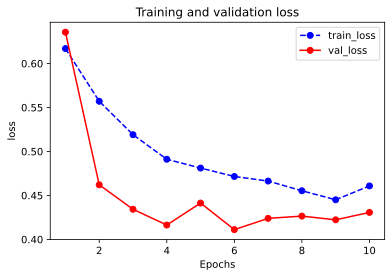

In [15]:
plot_metric(dfhistory,"loss")

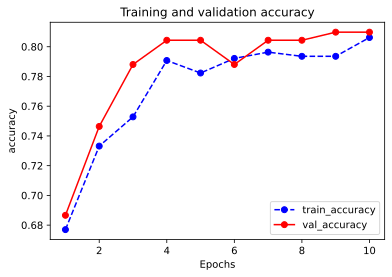

In [16]:
plot_metric(dfhistory,"accuracy")

## 使用模型

In [17]:
#预测概率
y_pred_probs = net(torch.tensor(x_test[0:10]).float()).data
y_pred_probs

tensor([[0.0922],
        [0.6885],
        [0.3821],
        [0.5708],
        [0.4357],
        [0.9087],
        [0.2186],
        [0.8685],
        [0.4825],
        [0.2263]])

## 保存模型

In [18]:
print(net.state_dict().keys())

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])


In [19]:
torch.save(net.state_dict(), "./data/net_parameter.pkl")

net_clone = create_net()
net_clone.load_state_dict(torch.load("./data/net_parameter.pkl"))

net_clone.forward(torch.tensor(x_test[0:10]).float()).data

tensor([[0.0922],
        [0.6885],
        [0.3821],
        [0.5708],
        [0.4357],
        [0.9087],
        [0.2186],
        [0.8685],
        [0.4825],
        [0.2263]])